In [36]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.decomposition import PCA

In [41]:
import mahala_ad.mahala_ad as mad

In [42]:
# Load data

train = pd.read_table("data/datatraining.txt", sep = ',')
train.index = pd.to_datetime(train.date)
train = train.drop('date', axis = 1)

test = pd.read_table("data/datatest.txt", sep = ",")
test.index = pd.to_datetime(test.date)
test = test.drop('date', axis = 1)

In [43]:
# Remove and save known anomalies from training data, save known anomalies from testing data

y_train = train.Occupancy
train_no_anomalies = train[train.Occupancy == 0].drop('Occupancy', axis = 1)
train_anomalies = train.drop('Occupancy', axis = 1)

y_test = test.Occupancy
test = test.drop('Occupancy', axis = 1)

In [44]:
norm_train, norm_train_anomalies, norm_test = mad.normalize_data(train_no_anomalies, train_anomalies, test)

pca_train, pca_train_anomalies, pca_test = mad.generate_PCA(norm_train, norm_train_anomalies, norm_test, 2)

In [45]:
# Find Mahalanobis Distance

x_train = np.array(pca_train.values)
x_train_anomalies = np.array(pca_train_anomalies.values)
x_test = np.array(pca_test.values)

inv_cov_train = mad.inv_cov_matrix(x_train)

means = x_train.mean(axis=0)

mdist_train = mad.calculate_M_distance(inv_cov_train, means, x_train)
mdist_train_anomalies = mad.calculate_M_distance(inv_cov_train, means, x_train_anomalies)
mdist_test = mad.calculate_M_distance(inv_cov_train, means, x_test)

threshold = mad.calculate_threshold(mdist_train, extreme = True)

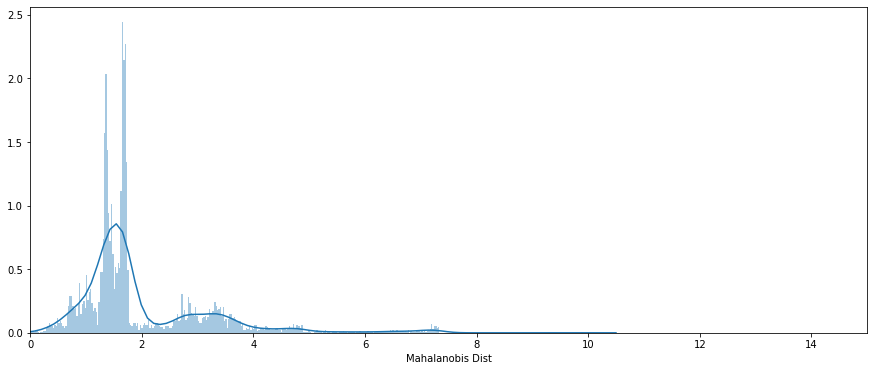

In [46]:
mad.plot_distances(mdist_train_anomalies)

In [47]:
# Label anomalies

train_anomaly = pd.DataFrame()
train_anomaly['Mob dist']= mdist_train_anomalies
train_anomaly['Thresh'] = threshold
train_anomaly['Anomaly'] = train_anomaly['Mob dist'] > train_anomaly['Thresh']
train_anomaly.index = pca_train_anomalies.index

anomaly = pd.DataFrame()
anomaly['Mob dist']= mdist_test
anomaly['Thresh'] = threshold
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = pca_test.index

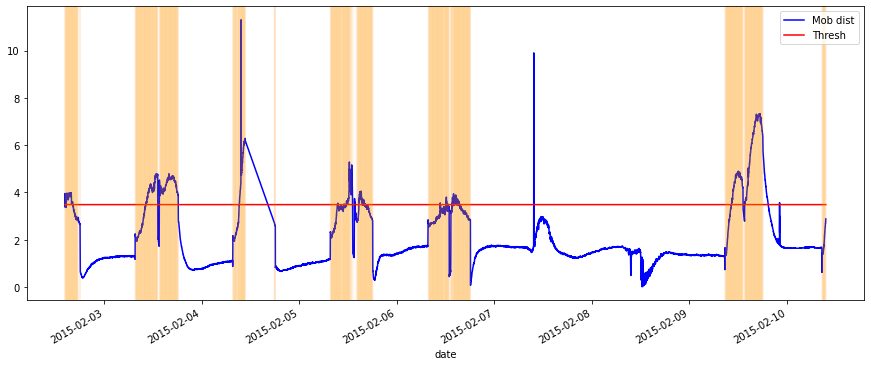

In [48]:
all_anomalies = pd.concat((train_anomaly, anomaly))
y = pd.concat((y_train, y_test))

mad.plot_detections(all_anomalies, y)